# Fit a global model on the data

- For any given year of data, the outcome of a game can be described as a bayesian model of the number of points

## Imports 
- JAX is now working with Metal GPU support on Apple Silicon!

In [57]:
import os
os.environ["JAX_PLATFORMS"]="cpu"

In [58]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Tuple, Iterable, TypedDict, Optional

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# For better numerical stability in Poisson log-rates
jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(1)

## Utils

In [59]:
class SeasonDF(TypedDict):
    gameID: int
    date: str
    home_team: str
    away_team: str
    home_score: int
    away_score: int
    finalMessage: str
    start_time: str
    url: str
    conference_home: str
    conference_away: str

@dataclass(frozen=True)
class EncodedSeason:
    home_idx: jnp.ndarray     # shape (n_games,), int32
    away_idx: jnp.ndarray     # shape (n_games,), int32
    y_home: jnp.ndarray       # shape (n_games,), int32
    y_away: jnp.ndarray       # shape (n_games,), int32
    n_teams: int
    id_to_team: List[str]
    team_to_id: Dict[str, int]


In [60]:
def _normalize_team_name(name: str) -> str:
    # light normalization to avoid accidental dupes
    return " ".join(name.strip().split())

def build_team_indexer(df: pd.DataFrame) -> Tuple[Dict[str, int], List[str]]:
    assert {"home_team", "away_team"}.issubset(df.columns), "Missing required columns."
    teams: List[str] = sorted({
        _normalize_team_name(t) for t in
        df["home_team"].astype(str).tolist() + df["away_team"].astype(str).tolist()
    })
    team_to_id = {t: i for i, t in enumerate(teams)}
    id_to_team = teams
    return team_to_id, id_to_team

def encode_season(df: pd.DataFrame, team_to_id: Dict[str, int]) -> EncodedSeason:

    req = {"home_team","away_team","home_score","away_score"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"DataFrame missing columns: {missing}")

    home_idx = df["home_team"].astype(str).map(lambda x: team_to_id[_normalize_team_name(x)]).astype(np.int32).to_numpy()
    away_idx = df["away_team"].astype(str).map(lambda x: team_to_id[_normalize_team_name(x)]).astype(np.int32).to_numpy()

    y_home = df["home_score"].astype(np.int32).to_numpy()
    y_away = df["away_score"].astype(np.int32).to_numpy()

    n_teams = len(team_to_id)
    id_to_team = [None] * n_teams  # type: ignore
    for t, i in team_to_id.items():
        id_to_team[i] = t  # fill by index

    return EncodedSeason(
        home_idx=jnp.array(home_idx),
        away_idx=jnp.array(away_idx),
        y_home=jnp.array(y_home),
        y_away=jnp.array(y_away),
        n_teams=n_teams,
        id_to_team=id_to_team,  # type: ignore
        team_to_id=team_to_id,
    )


In [61]:
def hierarchal_model(
    home_idx: jnp.ndarray,
    away_idx: jnp.ndarray,
    y_home: jnp.ndarray,
    y_away: jnp.ndarray,
    n_teams: int,
):
    # Intercept: weakly-informative
    alpha = numpyro.sample("alpha", dist.Normal(0.0, 5.0))

    # Hierarchy scales (positive)
    sigma_off = numpyro.sample("sigma_off", dist.HalfNormal(1.0))
    sigma_def = numpyro.sample("sigma_def", dist.HalfNormal(1.0))
    tau_h     = numpyro.sample("tau_h",     dist.HalfNormal(1.0))

    # League-level home advantage mean
    h_mu = numpyro.sample("h_mu", dist.Normal(0.0, 1.0))

    with numpyro.plate("team", n_teams):
        # Team-level effects drawn from distributions (not values)
        h       = numpyro.sample("h",       dist.Normal(h_mu, tau_h))
        offense = numpyro.sample("offense", dist.Normal(0.0, sigma_off))
        defense = numpyro.sample("defense", dist.Normal(0.0, sigma_def))

    # Linear predictors
    eta_home = alpha + offense[home_idx] - defense[away_idx] + h[home_idx]
    eta_away = alpha + offense[away_idx] - defense[home_idx]

    # Likelihood
    numpyro.sample("y_home", dist.Poisson(jnp.exp(eta_home)), obs=y_home)
    numpyro.sample("y_away", dist.Poisson(jnp.exp(eta_away)), obs=y_away)

def fit_hierarchal_model(encoded: EncodedSeason, seed: int = 0, num_chains: int = 2, num_warmup: int = 100, num_samples: int = 300):
    """
    Fit the model_hier_offdef_home model on an EncodedSeason.
    Returns the MCMC object and posterior samples.
    """
    home_idx = jnp.array(encoded.home_idx)
    away_idx = jnp.array(encoded.away_idx)
    y_home = jnp.array(encoded.y_home)
    y_away = jnp.array(encoded.y_away)
    n_teams = encoded.n_teams

    kernel = numpyro.infer.NUTS(hierarchal_model)
    mcmc = numpyro.infer.MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=True,
        chain_method="sequential"
    )
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(
        rng_key,
        home_idx=home_idx,
        away_idx=away_idx,
        y_home=y_home,
        y_away=y_away,
        n_teams=n_teams,
    )
    return mcmc, mcmc.get_samples()

## Global prior

In [62]:
df = pd.read_csv("/Users/arhamhabib/Projects/PostPick/data/ncaab_2021_men_d1.csv")
df.dropna(inplace=True, subset=['home_team', 'away_team', 'home_score', 'away_score'])
df

,gameID,date,home_team,away_team,home_score,away_score,finalMessage,start_time,url,conference_home,conference_away
0,1976847.0,2021-11-01,Florida,Embry-Riddle (FL),80.0,57.0,FINAL,12:00AM ET,5896325,SEC,Sunshine State
1,1976852.0,2021-11-01,Alcorn,Xavier (LA),67.0,45.0,FINAL,01:00AM ET,5896329,SWAC,NON-NCAA ORG
2,1976853.0,2021-11-01,Texas,Texas Lutheran,96.0,33.0,FINAL,01:00AM ET,5896330,Big 12,SCAC
3,1976854.0,2021-11-01,Oklahoma,Rogers St.,106.0,57.0,FINAL,01:00AM ET,5896331,Big 12,Mid-America Intercollegiate
4,1994143.0,2021-11-01,UAB,AUM,101.0,70.0,FINAL,01:00AM ET,5907144,C-USA,Gulf South
...,...,...,...,...,...,...,...,...,...,...,...
6114,2070074.0,2022-03-31,Texas A&M,Xavier,72.0,73.0,FINAL,07:00PM ET,5996538,SEC,Big East
6115,2076366.0,2022-04-01,Coastal Carolina,Fresno St.,74.0,85.0,FINAL,06:00PM ET,5996410,Sun Belt,Mountain West
6116,2070510.0,2022-04-02,Kansas,Villanova,81.0,65.0,FINAL,06:09PM ET,5958444,Big 12,Big East
6117,2070511.0,2022-04-02,Duke,North Carolina,77.0,81.0,FINAL,08:51PM ET,5958443,ACC,ACC


In [63]:
# 2) Build global index, encode, and fit EB hypers on the FULL SEASON (replace df with your full season df)
team_to_id, id_to_team = build_team_indexer(df)
encoded = encode_season(df, team_to_id)

In [64]:
mcmc, samples = fit_hierarchal_model(encoded)

sample: 100%|██████████| 400/400 [03:23<00:00,  1.96it/s, 1023 steps of size 3.58e-03. acc. prob=0.76]


In [9]:
for param, sample in samples.items():
    print(param, sample.mean())

alpha 4.2411208876633575
defense -0.0006628236906212456
h 0.04433317836325478
h_mu 0.04435785429850784
offense 0.0007113459772847094
sigma_def 0.14946920834711025
sigma_off 0.14247620727608085
tau_h 0.026948507515521955


In [19]:
# Find Duke's team ID
duke_id = team_to_id['Duke']
print(f"Duke's team ID: {duke_id}")

# Find another team for comparison (let's use North Carolina)
unc_id = team_to_id['North Carolina']
print(f"North Carolina's team ID: {unc_id}")

# Extract Duke's offense, defense, and home parameters
duke_offense = samples['offense'][:, duke_id]
duke_defense = samples['defense'][:, duke_id]
duke_home = samples['h'][:, duke_id]

# Extract North Carolina's offense, defense, and home parameters
unc_offense = samples['offense'][:, unc_id]
unc_defense = samples['defense'][:, unc_id]
unc_home = samples['h'][:, unc_id]

print(f"\n=== DUKE ===")
print(f"Offense:")
print(f"  Mean: {duke_offense.mean():.4f}")
print(f"  Standard deviation: {duke_offense.std():.4f}")
print(f"Defense:")
print(f"  Mean: {duke_defense.mean():.4f}")
print(f"  Standard deviation: {duke_defense.std():.4f}")
print(f"Home:")
print(f"  Mean: {duke_home.mean():.4f}")
print(f"  Standard deviation: {duke_home.std():.4f}")

print(f"\n=== NORTH CAROLINA ===")
print(f"Offense:")
print(f"  Mean: {unc_offense.mean():.4f}")
print(f"  Standard deviation: {unc_offense.std():.4f}")
print(f"Defense:")
print(f"  Mean: {unc_defense.mean():.4f}")
print(f"  Standard deviation: {unc_defense.std():.4f}")
print(f"Home:")
print(f"  Mean: {unc_home.mean():.4f}")
print(f"  Standard deviation: {unc_home.std():.4f}")

print(f"\n=== COMPARISON ===")
print(f"Offense difference (Duke - UNC): {duke_offense.mean() - unc_offense.mean():.4f}")
print(f"Defense difference (Duke - UNC): {duke_defense.mean() - unc_defense.mean():.4f}")
print(f"Home difference (Duke - UNC): {duke_home.mean() - unc_home.mean():.4f}")

# Calculate expected scores using the model's linear predictors
# This shows what the model predicts for actual game scores
alpha = samples['alpha'].mean()
duke_eta_home = alpha + duke_offense - unc_defense + duke_home
unc_eta_away = alpha + unc_offense - duke_defense

duke_expected_score = jnp.exp(duke_eta_home)
unc_expected_score = jnp.exp(unc_eta_away)

print(f"\n=== EXPECTED SCORES (Duke home vs UNC away) ===")
print(f"Duke expected score: {duke_expected_score.mean():.2f} ± {duke_expected_score.std():.2f}")
print(f"UNC expected score: {unc_expected_score.mean():.2f} ± {unc_expected_score.std():.2f}")

# Show some actual expected score samples
print(f"\nDuke expected scores (first 10): {duke_expected_score[:10]}")
print(f"UNC expected scores (first 10): {unc_expected_score[:10]}")

# Show sample values for both teams
print(f"\nDuke offense samples (first 10): {duke_offense[:10]}")
print(f"UNC offense samples (first 10): {unc_offense[:10]}")
print(f"Duke defense samples (first 10): {duke_defense[:10]}")
print(f"UNC defense samples (first 10): {unc_defense[:10]}")
print(f"Duke home samples (first 10): {duke_home[:10]}")
print(f"UNC home samples (first 10): {unc_home[:10]}")


Duke's team ID: 165
North Carolina's team ID: 440

=== DUKE ===
Offense:
  Mean: 0.2420
  Standard deviation: 0.0237
Defense:
  Mean: 0.1721
  Standard deviation: 0.0217
Home:
  Mean: 0.0495
  Standard deviation: 0.0233

=== NORTH CAROLINA ===
Offense:
  Mean: 0.2520
  Standard deviation: 0.0231
Defense:
  Mean: 0.1350
  Standard deviation: 0.0197
Home:
  Mean: 0.0228
  Standard deviation: 0.0220

=== COMPARISON ===
Offense difference (Duke - UNC): -0.0101
Defense difference (Duke - UNC): 0.0371
Home difference (Duke - UNC): 0.0266

=== EXPECTED SCORES (Duke home vs UNC away) ===
Duke expected score: 81.28 ± 2.27
UNC expected score: 75.30 ± 2.31

Duke expected scores (first 10): [77.99081254 79.02157234 81.06747455 81.34332579 80.10513408 81.74964812
 80.56509406 76.5173832  87.93854886 84.88015733]
UNC expected scores (first 10): [72.05974811 76.61917716 77.03885079 74.15775151 74.27669673 77.78629945
 73.41630119 74.26798247 75.5566175  72.25271845]

Duke offense samples (first 10): 

### Simulate team matchup

In [47]:
import numpy as np
import arviz as az

def simulate_match_pp(
    samples: dict,
    home_team: int,
    away_team: int,
    *,
    reps: int | None = None,       # how many simulated games; None => use all draws once (D)
    rng_seed: int | None = 0,
    make_plots: bool = True,
    return_idata: bool = True,
):
    """
    Posterior-predictive match simulation with FULL parameter uncertainty.

    Parameters
    ----------
    samples : dict
        From numpyro MCMC (mcmc.get_samples()). Must include: 'alpha','offense','defense','h'.
        Expected shapes:
          - alpha:   (D,) or (D,1)
          - offense: (D, T)
          - defense: (D, T)
          - h:       (D, T)
        where D = # draws, T = # teams (746 here).
    home_team, away_team : int
        0-based team indices.
    reps : int | None
        Number of posterior-predictive games to simulate.
        If None, uses every posterior draw exactly once (R = D).
        If set, draws R parameter sets *with replacement* from the D posterior draws.
    rng_seed : int | None
        RNG seed for reproducibility.
    make_plots : bool
        If True, show ArviZ posterior histograms for y_home, y_away, goal_diff.
    return_idata : bool
        If True, return ArviZ InferenceData.

    Returns
    -------
    dict with keys:
      y_home, y_away, goal_diff, p_home_win, p_draw, p_away_win, idata (maybe None)
    """
    rng = np.random.default_rng(rng_seed)

    # Pull and coerce shapes
    alpha   = np.asarray(samples["alpha"]).reshape(-1)          # (D,)
    offense = np.asarray(samples["offense"])                    # (D, T)
    defense = np.asarray(samples["defense"])                    # (D, T)
    h       = np.asarray(samples["h"])                          # (D, T)

    if offense.ndim != 2 or defense.ndim != 2 or h.ndim != 2:
        raise ValueError("offense/defense/h must be 2D (draws, teams).")
    D, T = offense.shape
    if defense.shape != (D, T) or h.shape != (D, T):
        raise ValueError(f"Shape mismatch: offense {offense.shape}, defense {defense.shape}, h {h.shape}")
    if alpha.shape[0] != D:
        raise ValueError(f"alpha draws {alpha.shape[0]} != team-effect draws {D}")
    if not (0 <= home_team < T and 0 <= away_team < T):
        raise IndexError(f"Team index out of range: home={home_team}, away={away_team}, T={T}")

    # Choose which posterior draws to use for the sims
    if reps is None:
        draw_idx = np.arange(D)              # use each draw once (R = D)
    else:
        draw_idx = rng.integers(0, D, size=int(reps))  # sample draws w/ replacement (R = reps)

    # Gather the selected draws
    a   = alpha[draw_idx]                    # (R,)
    off = offense[draw_idx, :]               # (R, T)
    de  = defense[draw_idx, :]               # (R, T)
    hh  = h[draw_idx, :]                     # (R, T)

    # Linear predictors & Poisson rates per simulated game
    eta_home = a + off[:, home_team] - de[:, away_team] + hh[:, home_team]   # (R,)
    eta_away = a + off[:, away_team] - de[:, home_team]                      # (R,)
    lam_home = np.exp(eta_home)
    lam_away = np.exp(eta_away)

    # Posterior predictive scores
    y_home = rng.poisson(lam_home)
    y_away = rng.poisson(lam_away)
    goal_diff = y_home - y_away

    # Outcome probabilities
    p_home_win = float((goal_diff > 0).mean())
    p_draw     = float((goal_diff == 0).mean())
    p_away_win = float((goal_diff < 0).mean())

    # Optional ArviZ packaging + quick plots
    idata = None
    if return_idata:
        idata = az.from_dict(
            posterior_predictive={
                "y_home":    y_home[None, :],    # (chain=1, draw=R)
                "y_away":    y_away[None, :],
                "goal_diff": goal_diff[None, :],
            }
        )
        if make_plots:
            az.plot_posterior(
                idata,
                var_names=["y_home", "y_away", "goal_diff"],
                group="posterior_predictive",
                kind="hist",
                hdi_prob=0.90,
            )
            print(
                f"Home win: {p_home_win:.3f} | Draw: {p_draw:.3f} | Away win: {p_away_win:.3f} "
                f"(based on {y_home.size} posterior-predictive sims)"
            )

    return {
        "y_home": y_home,
        "y_away": y_away,
        "goal_diff": goal_diff,
        "p_home_win": p_home_win,
        "p_draw": p_draw,
        "p_away_win": p_away_win,
        "idata": idata,
    }


Home win: 0.478 | Draw: 0.017 | Away win: 0.505 (based on 600 posterior-predictive sims)


(0.47833333333333333, 0.016666666666666666, 0.505)

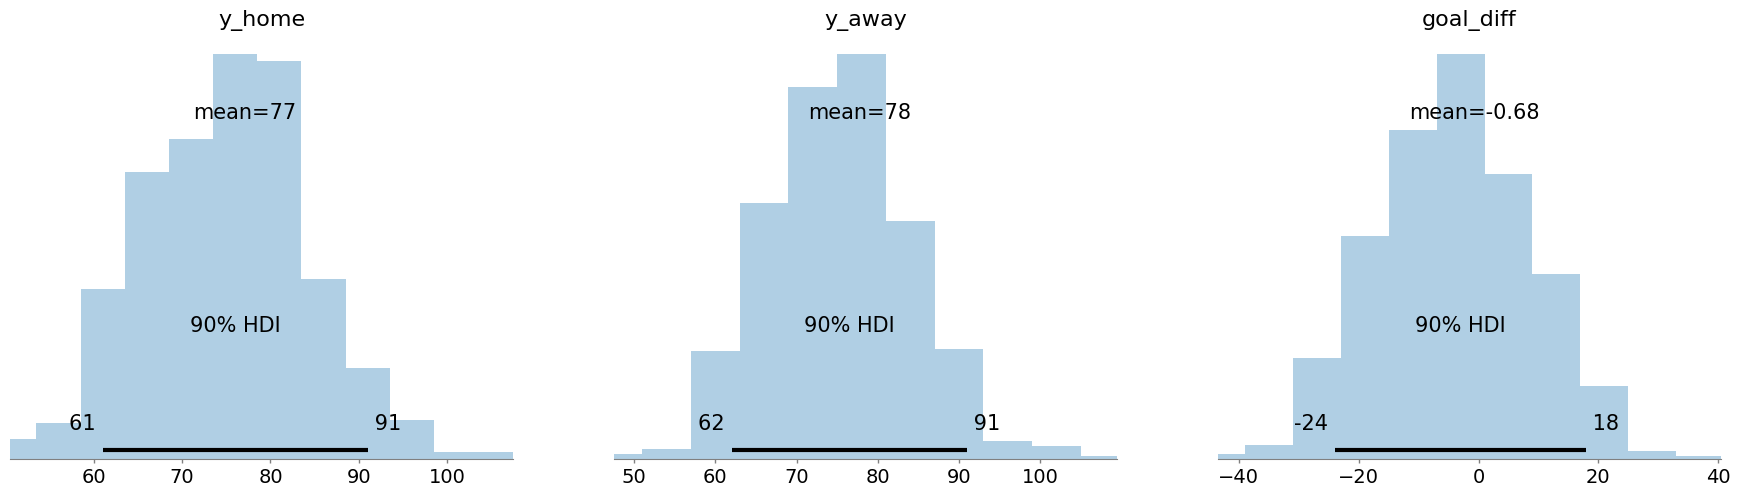

In [55]:
# D=600 draws, T=746 teams
out = simulate_match_pp(
    samples,
    home_team=440,
    away_team=165,
    reps=None,         # uses all 600 draws once (parameter uncertainty preserved)
    rng_seed=52,
    make_plots=True,
    return_idata=True,
)

out["p_home_win"], out["p_draw"], out["p_away_win"]


In [56]:
out['y_home']

array([ 76,  76,  78,  73,  87,  70,  76,  82,  76,  74,  81,  86,  84,
        72,  72,  75,  65,  81,  78,  77,  76,  69,  82,  73,  88,  58,
        76,  70,  81,  71,  70,  83,  64,  82,  94,  84,  74,  67,  96,
        84,  72,  93,  77,  68,  68,  64,  82,  68,  83,  74,  83,  63,
        55,  81, 106,  72,  66,  65,  91,  58,  57,  74,  63,  74,  76,
        84,  81,  86,  63,  63,  74,  66,  55,  82,  74,  61,  73,  69,
        77,  75,  81,  73,  86,  89,  82,  76,  74,  90,  78,  77,  73,
        70,  68,  81,  83,  73,  64,  78,  70,  90,  85,  71,  79,  77,
        65,  67,  75,  82,  77,  91,  62,  72,  81,  77,  76,  79,  58,
        62,  85,  82,  84,  74,  75,  73,  88,  84,  85,  81,  80,  89,
        76,  75,  70,  69,  73,  71,  77,  75,  84,  68,  90,  88,  69,
        77,  70,  66,  58,  90,  64,  70,  81,  85,  79,  84,  71,  82,
        73,  84,  84,  90,  63,  75,  78,  82,  73,  79,  82,  81,  83,
        78,  82,  71,  76,  90,  71,  84,  84,  90,  80,  99,  7

In [38]:
samples.keys()

dict_keys(['alpha', 'defense', 'h', 'h_mu', 'offense', 'sigma_def', 'sigma_off', 'tau_h'])

In [39]:
samples['alpha'].shape

(600,)

In [40]:
samples['defense'].shape

(600, 746)

In [41]:
samples['h_mu'].shape

(600,)

In [42]:
samples['sigma_def'].shape

(600,)